In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def AND(x1,x2):
    y = 0
    if x1==1 and x2==1:
        y = 1
    return y

def OR(x1,x2):
    y = 0
    if x1==1 or x2==1:
        y = 1
    return y

def NOR1(x1,x2):
    y = 0
    if x1==1 and x2==0:
        y = 1
    return y

def NOR2(x1,x2):
    y = 0
    if x1==0 and x2==1:
        y = 1
    return y

def generate_samples(func):
    x1,x2 = (np.random.random(2)<0.5).astype(int)
    y = func(x1,x2)
    y = torch.tensor(y).type(torch.float32)
    return x1,x2,y

Global min:  tensor([0.3434]) tensor([0.3434])


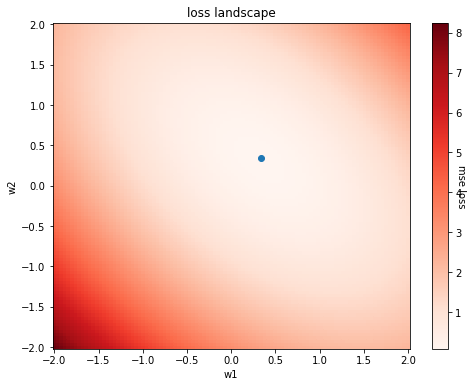

In [104]:
def loss_function(w1, w2, target_func, threshold=0):
    x = [(0,1),
         (1,0),
         (1,1),
         (0,0)]
    
    if type(w1) == torch.tensor:
        loss = torch.zeros(w1.shape)
    else:
        loss = 0
        
    for x1,x2 in x:
        z = x1*w1 + x2*w2
        y_predicted = (z-threshold)
        y_target = target_func(x1,x2)
        loss += (y_target - y_predicted)**2
    
    mse_loss = loss / len(x)
    return mse_loss

def plot_loss_landscape(target_func):
    max_weight = 2
    w1 = torch.linspace(-max_weight, max_weight, 100)
    w2 = torch.linspace(-max_weight, max_weight, 100)

    w1_mesh, w2_mesh = torch.meshgrid(w1, w2)
        
    plt.figure(figsize=(8,6))
    plt.pcolormesh(w1_mesh, w2_mesh,
                   loss_function(w1_mesh, w2_mesh, target_func),
                   shading='nearest',
                   cmap='Reds')
    plt.xlabel('w1')
    plt.ylabel('w2')
    cbar = plt.colorbar()
    cbar.set_label('mse loss', rotation=-90.)
    
    loss_landscape = loss_function(w1_mesh, w2_mesh, target_func)
    global_min = torch.min(loss_landscape)
    min_idx = torch.where(loss_landscape==global_min)
    plt.scatter(w1_mesh[min_idx],w2_mesh[min_idx])
    
    print("Global min: ", w1_mesh[min_idx], w2_mesh[min_idx])

    plt.title('loss landscape')
    plt.show()
    
plot_loss_landscape(AND)

In [105]:
class BinaryClassifier_backprop(nn.Module):
    
    def __init__(self, init_weights, lr, threshold=0):
        super().__init__()
        self.weights = nn.Parameter(init_weights)
        self.threshold = threshold
        
        self.lossCriterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
        
    def forward(self, x1, x2):
        z = x1*self.weights[0] + x2*self.weights[1]
        y_predicted = (z - self.threshold)
        return y_predicted
    
    
    def train(self, n_epochs, target_func):
        self.target_func = target_func
        
        weight_history = torch.zeros(n_epochs,2)
        loss_history = torch.zeros(n_epochs)
        
        for i in range(n_epochs):
            weight_history[i] = self.weights.detach()
            
            x1, x2, y_target = generate_samples(target_func)
            y_predicted = self.forward(x1,x2)
            self.optimizer.zero_grad()
            loss = self.lossCriterion(y_predicted,y_target)           
            loss.backward()
            self.optimizer.step()
            
            loss_history[i] = loss.detach()
            
        self.weight_history = weight_history
        self.loss_history = loss_history
        

    def plot_loss_landscape(self):
        max_weight = 2
        w1 = torch.linspace(-max_weight, max_weight, 100)
        w2 = torch.linspace(-max_weight, max_weight, 100)

        w1_mesh, w2_mesh = torch.meshgrid(w1, w2)

        fig, ax = plt.subplots(1,2,figsize=(15,5))
        im = ax[0].pcolormesh(w1_mesh, w2_mesh,
                       loss_function(w1_mesh, w2_mesh, self.target_func),
                       shading='nearest',
                       cmap='Reds')
        ax[0].set_xlabel('w1')
        ax[0].set_ylabel('w2')
        ax[0].set_title('loss landscape')
        cbar = fig.colorbar(im, ax=ax[0])
        cbar.set_label('mse loss', rotation=-90.)
        
        loss_landscape = loss_function(w1_mesh, w2_mesh, self.target_func)
        global_min = torch.min(loss_landscape)
        min_idx = torch.where(loss_landscape==global_min)
        ax[0].scatter(w1_mesh[min_idx],w2_mesh[min_idx],color='black')
        ax[0].plot(self.weight_history[:,0],model.weight_history[:,1])
        
        ax[1].plot(self.loss_history)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('MSE Loss')
        
        print("Global min: ", w1_mesh[min_idx], w2_mesh[min_idx])

        plt.show()

Final weights:  tensor([ 0.7374, -0.3883])
Global min:  tensor([0.6667]) tensor([-0.3434])


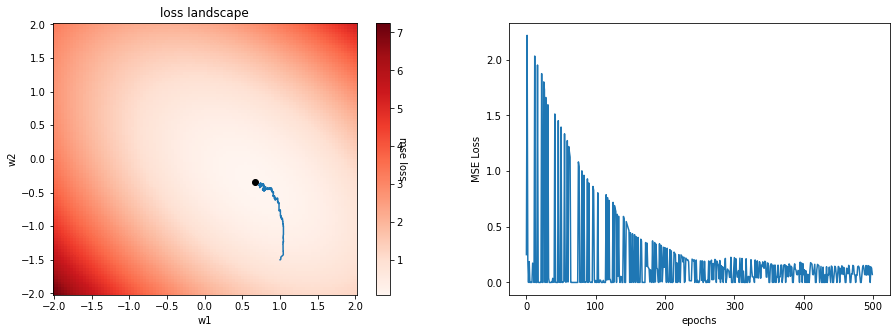

In [120]:
init_weights = torch.tensor([1,-1.5])
model = BinaryClassifier_backprop(init_weights, lr=0.01)

model.train(n_epochs=500, target_func=NOR1)
print("Final weights: ", model.weights.detach())

model.plot_loss_landscape()

# Training the same network with BTSP

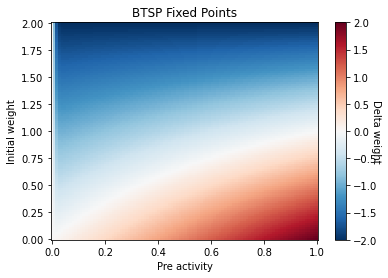

In [119]:
from matplotlib.ticker import MultipleLocator
from scipy import stats

def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]

tweaked_sigmoid = scaled_single_sigmoid(0.01, 0.02)
def btsp_rule(Pre, Mod, W, Wmax=2., k_pot=1, k_dep=1, k_decay=0.3, weight_decay=False):
    if weight_decay:
        dW = k_pot*(Wmax - W)*Pre*Mod - k_dep*W*tweaked_sigmoid(Pre * Mod) - (k_decay * Pre)# * post)
    else:
        dW = k_pot*(Wmax - W)*Pre*Mod - k_dep*W*tweaked_sigmoid(Pre * Mod)
#     else:
#         out = k_pot*(I*Wmax - W)*E - I*k_dep*W*tweaked_sigmoid(E*I)
    return dW


learning_rate = 0.25
input_peak_rate = 2.0

pre = np.linspace(-0., 1, 100)
# w0 = np.linspace(0., max_weight_scale, 100)

# pre = np.linspace(-input_peak_rate, input_peak_rate, 100)
w0 = np.linspace(-0, 2, 100)

pre_mesh, w0_mesh = np.meshgrid(pre, w0)
plt.figure()
# plt.pcolormesh(pre_mesh, w0_mesh,
#                btsp_rule(pre_mesh, Mod=1, W=w0_mesh),
#                cmap='RdBu_r', shading='nearest',
#                vmin=-2 * learning_rate, vmax=2 * .25)
minmax = np.max(np.abs(btsp_rule(pre_mesh, Mod=1, W=w0_mesh)))
plt.pcolormesh(pre_mesh, w0_mesh,
               btsp_rule(pre_mesh, Mod=1, W=w0_mesh),
               cmap='RdBu_r', shading='nearest',
               vmin=-minmax,vmax=minmax)
plt.xlabel('Pre activity')
plt.ylabel('Initial weight')
cbar = plt.colorbar()
cbar.set_label('Delta weight', rotation=-90.)
plt.title('BTSP Fixed Points')
plt.show()

In [80]:
class BinaryClassifier_BTSP():    
    '''
    Linear NN classifier with 2 inputs, 1 output (i.e. 2 weights)
    '''
    def __init__(self, init_weights, lr, threshold=0):
        super().__init__()
        self.weights = nn.Parameter(init_weights)
        self.threshold = threshold

        
    def forward(self, x1, x2):
        z = x1*self.weights[0] + x2*self.weights[1]
        y_predicted = (z - self.threshold)
        return y_predicted
    
    
    def compute_mod(self, y_predicted, y_target):
        error = y_target - y_predicted
        threshold = 0.2
        
        mod = error > threshold
        mod = mod.astype(int)
            
        return mod
    
    
    def train(self, n_epochs, target_func):
        self.target_func = target_func
        
        weight_history = torch.zeros(n_epochs,2)
        mod_history = np.zeros(n_epochs)
        loss_history = torch.zeros(n_epochs)
        
        for i in range(n_epochs):
            weight_history[i] = self.weights.detach()
            
            x1, x2, y_target = generate_samples(target_func)
            y_predicted = self.forward(x1,x2)
            
            mod = self.compute_mod(y_predicted, y_target)
            

            loss_history[i] = loss.detach()
            
        self.weight_history = weight_history
        self.loss_history = loss_history
            
        
    def train(self, x, y_true, lr, n_ep):

        for i in range(n_ep):
            y_prediction, hidden = self.forward(x)
            mod = self.compute_mod(y_prediction, y_true)
            
            for x_i,h_i,mod_i in zip(x,hidden,mod):
                dw1 = btsp_rule(Pre=x_i, Mod=mod_i, W=self.weights[0])
                
                self.w1 += lr * dw1
                self.w2 += lr * dw2
            
            mse_loss = np.mean((y_true - y_prediction)**2)
            loss_history[i] = mse_loss
            mod_history[i] = np.mean(mod)
            weight_history[i] = [self.w1, self.w2]

        self.loss_history = loss_history
        self.mod_history = mod_history
        self.weight_history = weight_history

SyntaxError: unexpected EOF while parsing (<ipython-input-80-1db28431e1be>, line 2)

In [ ]:
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

BTSP_model = BinaryClassifier_BTSP(init_weights, lr=0.02)

BTSP_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval,hidden_eval = BTSP_model.forward(x_eval)

# print(x_train.shape,y_train.shape, x_eval.shape,y_eval.shape,mod_history.shape,weight_history.shape)
plot_x_y_(x_train, y_train, x_eval, y_eval, loss_history, weight_history)